# Fit a global model on the data

- For any given year of data, the outcome of a game can be described as a bayesian model of the number of points

## Imports 
- JAX is now working with Metal GPU support on Apple Silicon!

In [1]:
import os
os.environ["JAX_PLATFORMS"]="cpu"

In [29]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Tuple, Iterable, TypedDict, Optional

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import seaborn as sns

import matplotlib.pyplot as plt

# For better numerical stability in Poisson log-rates
jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(1)

## Utils

In [30]:
class SeasonDF(TypedDict):
    gameID: int
    date: str
    home_team: str
    away_team: str
    home_score: int
    away_score: int
    finalMessage: str
    start_time: str
    url: str
    conference_home: str
    conference_away: str

@dataclass(frozen=True)
class EncodedSeason:
    home_idx: jnp.ndarray     # shape (n_games,), int32
    away_idx: jnp.ndarray     # shape (n_games,), int32
    y_home: jnp.ndarray       # shape (n_games,), int32
    y_away: jnp.ndarray       # shape (n_games,), int32
    n_teams: int
    id_to_team: List[str]
    team_to_id: Dict[str, int]


In [ ]:
def _normalize_team_name(name: str) -> str:
    # light normalization to avoid accidental dupes
    return " ".join(name.strip().split())

def build_team_indexer(df: pd.DataFrame) -> Tuple[Dict[str, int], List[str]]:
    assert {"home_team", "away_team"}.issubset(df.columns), "Missing required columns."
    teams: List[str] = sorted({
        _normalize_team_name(t) for t in
        df["home_team"].astype(str).tolist() + df["away_team"].astype(str).tolist()
    })
    team_to_id = {t: i for i, t in enumerate(teams)}
    id_to_team = teams
    return team_to_id, id_to_team

def encode_season(df: pd.DataFrame, team_to_id: Dict[str, int]) -> EncodedSeason:

    req = {"home_team","away_team","home_score","away_score"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"DataFrame missing columns: {missing}")

    home_idx = df["home_team"].astype(str).map(lambda x: team_to_id[_normalize_team_name(x)]).astype(np.int32).to_numpy()
    away_idx = df["away_team"].astype(str).map(lambda x: team_to_id[_normalize_team_name(x)]).astype(np.int32).to_numpy()

    y_home = df["home_score"].astype(np.int32).to_numpy()
    y_away = df["away_score"].astype(np.int32).to_numpy()

    n_teams = len(team_to_id)
    id_to_team = [None] * n_teams  # type: ignore
    for t, i in team_to_id.items():
        id_to_team[i] = t  # fill by index

    return EncodedSeason(
        home_idx=jnp.array(home_idx),
        away_idx=jnp.array(away_idx),
        y_home=jnp.array(y_home),
        y_away=jnp.array(y_away),
        n_teams=n_teams,
        id_to_team=id_to_team,  # type: ignore
        team_to_id=team_to_id,
    )

def drop_teams_with_few_games(df, n=30):
    """
    Drops teams from the dataframe that have fewer than n unique games (home or away).
    Returns a filtered dataframe.
    """
    # Count number of unique games for each team (home or away)
    team_games = {}

    for _, row in df.iterrows():
        home = row['home_team']
        away = row['away_team']
        game_id = row['gameID']
        # Add game to home team
        if home not in team_games:
            team_games[home] = set()
        team_games[home].add(game_id)
        # Add game to away team
        if away not in team_games:
            team_games[away] = set()
        team_games[away].add(game_id)

    # Find teams with at least n games
    teams_to_keep = {team for team, games in team_games.items() if len(games) >= n}

    # Filter dataframe to only keep games where both teams are in teams_to_keep
    filtered_df = df[
        df['home_team'].isin(teams_to_keep) & df['away_team'].isin(teams_to_keep)
    ].copy()

    return filtered_df


In [32]:
df = pd.read_csv("/Users/arhamhabib/Projects/PostPick/data/ncaab_2021_men_d1.csv")
df.dropna(inplace=True, subset=['home_team', 'away_team', 'home_score', 'away_score'])
df

,gameID,date,home_team,away_team,home_score,away_score,finalMessage,start_time,url,conference_home,conference_away
0,1976847.0,2021-11-01,Florida,Embry-Riddle (FL),80.0,57.0,FINAL,12:00AM ET,5896325,SEC,Sunshine State
1,1976852.0,2021-11-01,Alcorn,Xavier (LA),67.0,45.0,FINAL,01:00AM ET,5896329,SWAC,NON-NCAA ORG
2,1976853.0,2021-11-01,Texas,Texas Lutheran,96.0,33.0,FINAL,01:00AM ET,5896330,Big 12,SCAC
3,1976854.0,2021-11-01,Oklahoma,Rogers St.,106.0,57.0,FINAL,01:00AM ET,5896331,Big 12,Mid-America Intercollegiate
4,1994143.0,2021-11-01,UAB,AUM,101.0,70.0,FINAL,01:00AM ET,5907144,C-USA,Gulf South
...,...,...,...,...,...,...,...,...,...,...,...
6114,2070074.0,2022-03-31,Texas A&M,Xavier,72.0,73.0,FINAL,07:00PM ET,5996538,SEC,Big East
6115,2076366.0,2022-04-01,Coastal Carolina,Fresno St.,74.0,85.0,FINAL,06:00PM ET,5996410,Sun Belt,Mountain West
6116,2070510.0,2022-04-02,Kansas,Villanova,81.0,65.0,FINAL,06:09PM ET,5958444,Big 12,Big East
6117,2070511.0,2022-04-02,Duke,North Carolina,77.0,81.0,FINAL,08:51PM ET,5958443,ACC,ACC


In [6]:
df = drop_teams_with_few_games(df, n=10)
df

,gameID,date,home_team,away_team,home_score,away_score,finalMessage,start_time,url,conference_home,conference_away
103,1977233.0,2021-11-09,Washington St.,Alcorn,85.0,67.0,FINAL,03:00PM ET,5896502,Pac-12,SWAC
104,1977237.0,2021-11-09,Villanova,Mount St. Mary's,91.0,51.0,FINAL,04:30PM ET,5896505,Big East,NEC
105,1977185.0,2021-11-09,South Fla.,Bethune-Cookman,75.0,54.0,FINAL,05:00PM ET,5896454,AAC,SWAC
106,1977234.0,2021-11-09,California,UC San Diego,67.0,80.0,FINAL,05:00PM ET,5896503,Pac-12,Big West
108,1977159.0,2021-11-09,Indiana,Eastern Mich.,68.0,62.0,FINAL,06:00PM ET,5896429,Big Ten,MAC
...,...,...,...,...,...,...,...,...,...,...,...
6114,2070074.0,2022-03-31,Texas A&M,Xavier,72.0,73.0,FINAL,07:00PM ET,5996538,SEC,Big East
6115,2076366.0,2022-04-01,Coastal Carolina,Fresno St.,74.0,85.0,FINAL,06:00PM ET,5996410,Sun Belt,Mountain West
6116,2070510.0,2022-04-02,Kansas,Villanova,81.0,65.0,FINAL,06:09PM ET,5958444,Big 12,Big East
6117,2070511.0,2022-04-02,Duke,North Carolina,77.0,81.0,FINAL,08:51PM ET,5958443,ACC,ACC


In [43]:
df[df.home_team.str.contains("Cal")]

,gameID,date,home_team,away_team,home_score,away_score,finalMessage,start_time,url,conference_home,conference_away
30,1976858.0,2021-11-01,California,Cal State LA,92.0,58.0,FINAL,09:00PM ET,5896335,Pac-12,CCAA
46,2002314.0,2021-11-03,Cal Poly,Cal State LA,87.0,70.0,FINAL,09:00PM ET,5926786,Big West,CCAA
106,1977234.0,2021-11-09,California,UC San Diego,67.0,80.0,FINAL,05:00PM ET,5896503,Pac-12,Big West
257,1977247.0,2021-11-09,Southern California,CSUN,89.0,49.0,FINAL,09:00PM ET,5896511,Pac-12,Big West
277,1977322.0,2021-11-09,Cal Poly,Westcliff,86.0,53.0,FINAL,10:00PM ET,5896558,Big West,NON-NCAA ORG
...,...,...,...,...,...,...,...,...,...,...,...
5900,2066056.0,2022-03-10,Cal St. Fullerton,UC Davis,73.0,55.0,FINAL,09:00PM ET,5984952,Big West,Big West
5910,2067300.0,2022-03-10,Southern California,Washington,65.0,61.0,FINAL,11:30PM ET,5985633,Pac-12,Pac-12
5955,2066048.0,2022-03-11,Cal St. Fullerton,Hawaii,58.0,46.0,FINAL,11:30PM ET,5988863,Big West,Big West
6034,2070054.0,2022-03-18,Southern California,Miami (FL),66.0,68.0,FINAL,03:23PM ET,5958413,Pac-12,ACC


In [7]:
# 2) Build global index, encode, and fit EB hypers on the FULL SEASON (replace df with your full season df)
team_to_id, id_to_team = build_team_indexer(df)
encoded = encode_season(df, team_to_id)

# Step one: global model on the data

## Fit global model

In [ ]:
def hierarchal_model(
    home_idx: jnp.ndarray,
    away_idx: jnp.ndarray,
    y_home: jnp.ndarray,
    y_away: jnp.ndarray,
    n_teams: int,
):
    # Intercept: weakly-informative
    alpha = numpyro.sample("alpha", dist.Normal(0.0, 5.0))

    # Hierarchy scales (positive)
    sigma_off = numpyro.sample("sigma_off", dist.HalfNormal(1.0))
    sigma_def = numpyro.sample("sigma_def", dist.HalfNormal(1.0))
    tau_h     = numpyro.sample("tau_h",     dist.HalfNormal(1.0))

    # League-level home advantage mean
    h_mu = numpyro.sample("h_mu", dist.Normal(0.0, 1.0))

    with numpyro.plate("team", n_teams):
        # Team-level effects drawn from distributions (not values)
        h       = numpyro.sample("h",       dist.Normal(h_mu, tau_h))
        offense = numpyro.sample("offense", dist.Normal(0.0, sigma_off))
        defense = numpyro.sample("defense", dist.Normal(0.0, sigma_def))

    # Linear predictors
    eta_home = alpha + offense[home_idx] - defense[away_idx] + h[home_idx]
    eta_away = alpha + offense[away_idx] - defense[home_idx]

    # Likelihood
    numpyro.sample("y_home", dist.Poisson(jnp.exp(eta_home)), obs=y_home)
    numpyro.sample("y_away", dist.Poisson(jnp.exp(eta_away)), obs=y_away)

def fit_hierarchal_model(encoded: EncodedSeason, seed: int = 0, num_chains: int = 2, num_warmup: int = 100, num_samples: int = 300):
    """
    Fit the model_hier_offdef_home model on an EncodedSeason.
    Returns the MCMC object and posterior samples.
    """
    home_idx = jnp.array(encoded.home_idx)
    away_idx = jnp.array(encoded.away_idx)
    y_home = jnp.array(encoded.y_home)
    y_away = jnp.array(encoded.y_away)
    n_teams = encoded.n_teams

    kernel = numpyro.infer.NUTS(hierarchal_model)
    mcmc = numpyro.infer.MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=True,
        chain_method="sequential"
    )
    rng_key = jax.random.PRNGKey(seed)
    mcmc.run(
        rng_key,
        home_idx=home_idx,
        away_idx=away_idx,
        y_home=y_home,
        y_away=y_away,
        n_teams=n_teams
    )
    samples = mcmc.get_samples()
    return mcmc, samples

In [13]:
mcmc, samples = fit_hierarchal_model(encoded)

sample: 100%|██████████| 400/400 [02:45<00:00,  2.42it/s, 511 steps of size 1.34e-03. acc. prob=0.97] 


In [36]:
arviz_object = az.from_numpyro(mcmc)

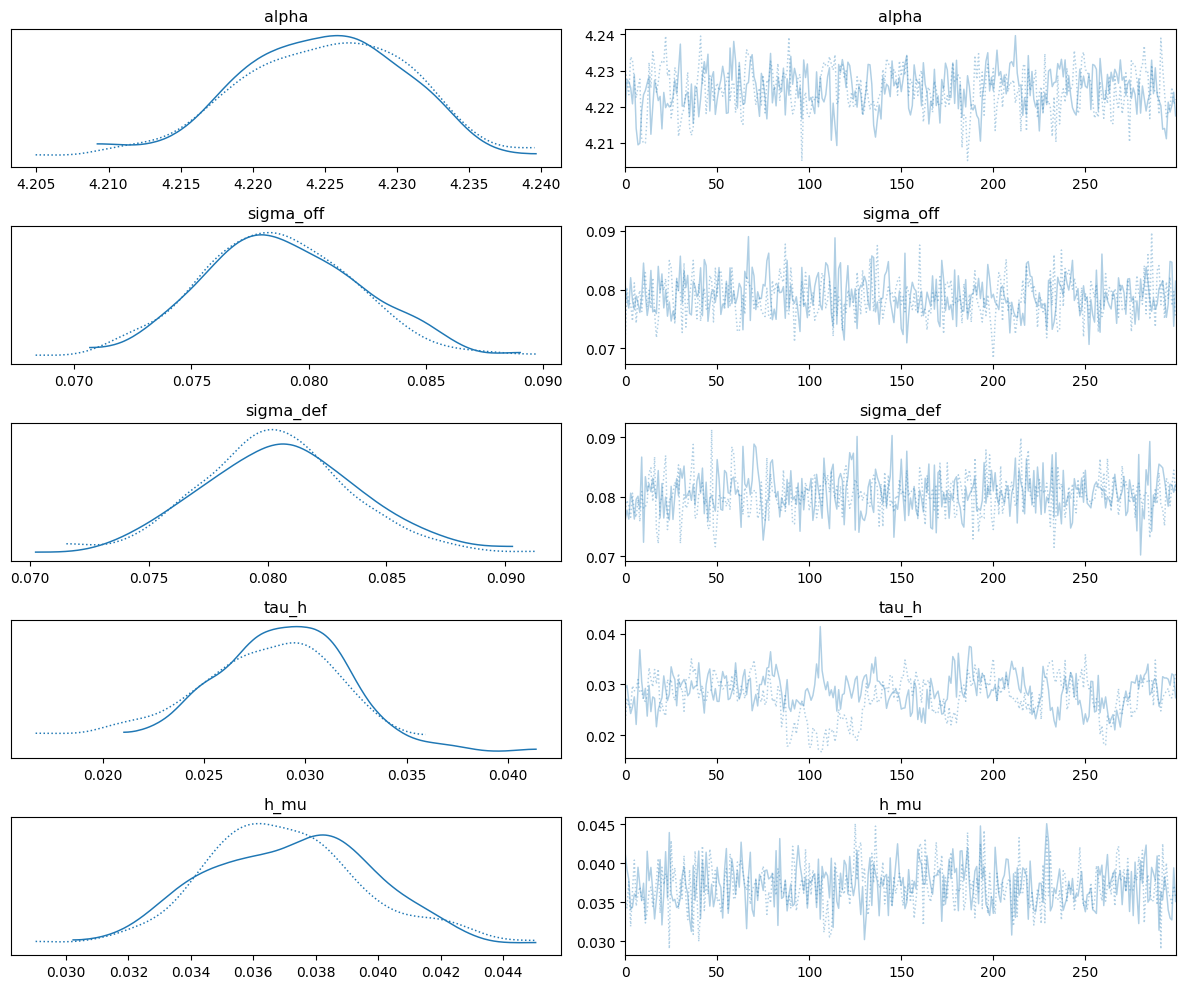

In [37]:
az.plot_trace(arviz_object, var_names=["alpha", "sigma_off", "sigma_def", "tau_h", "h_mu"])
plt.tight_layout()
plt.show()

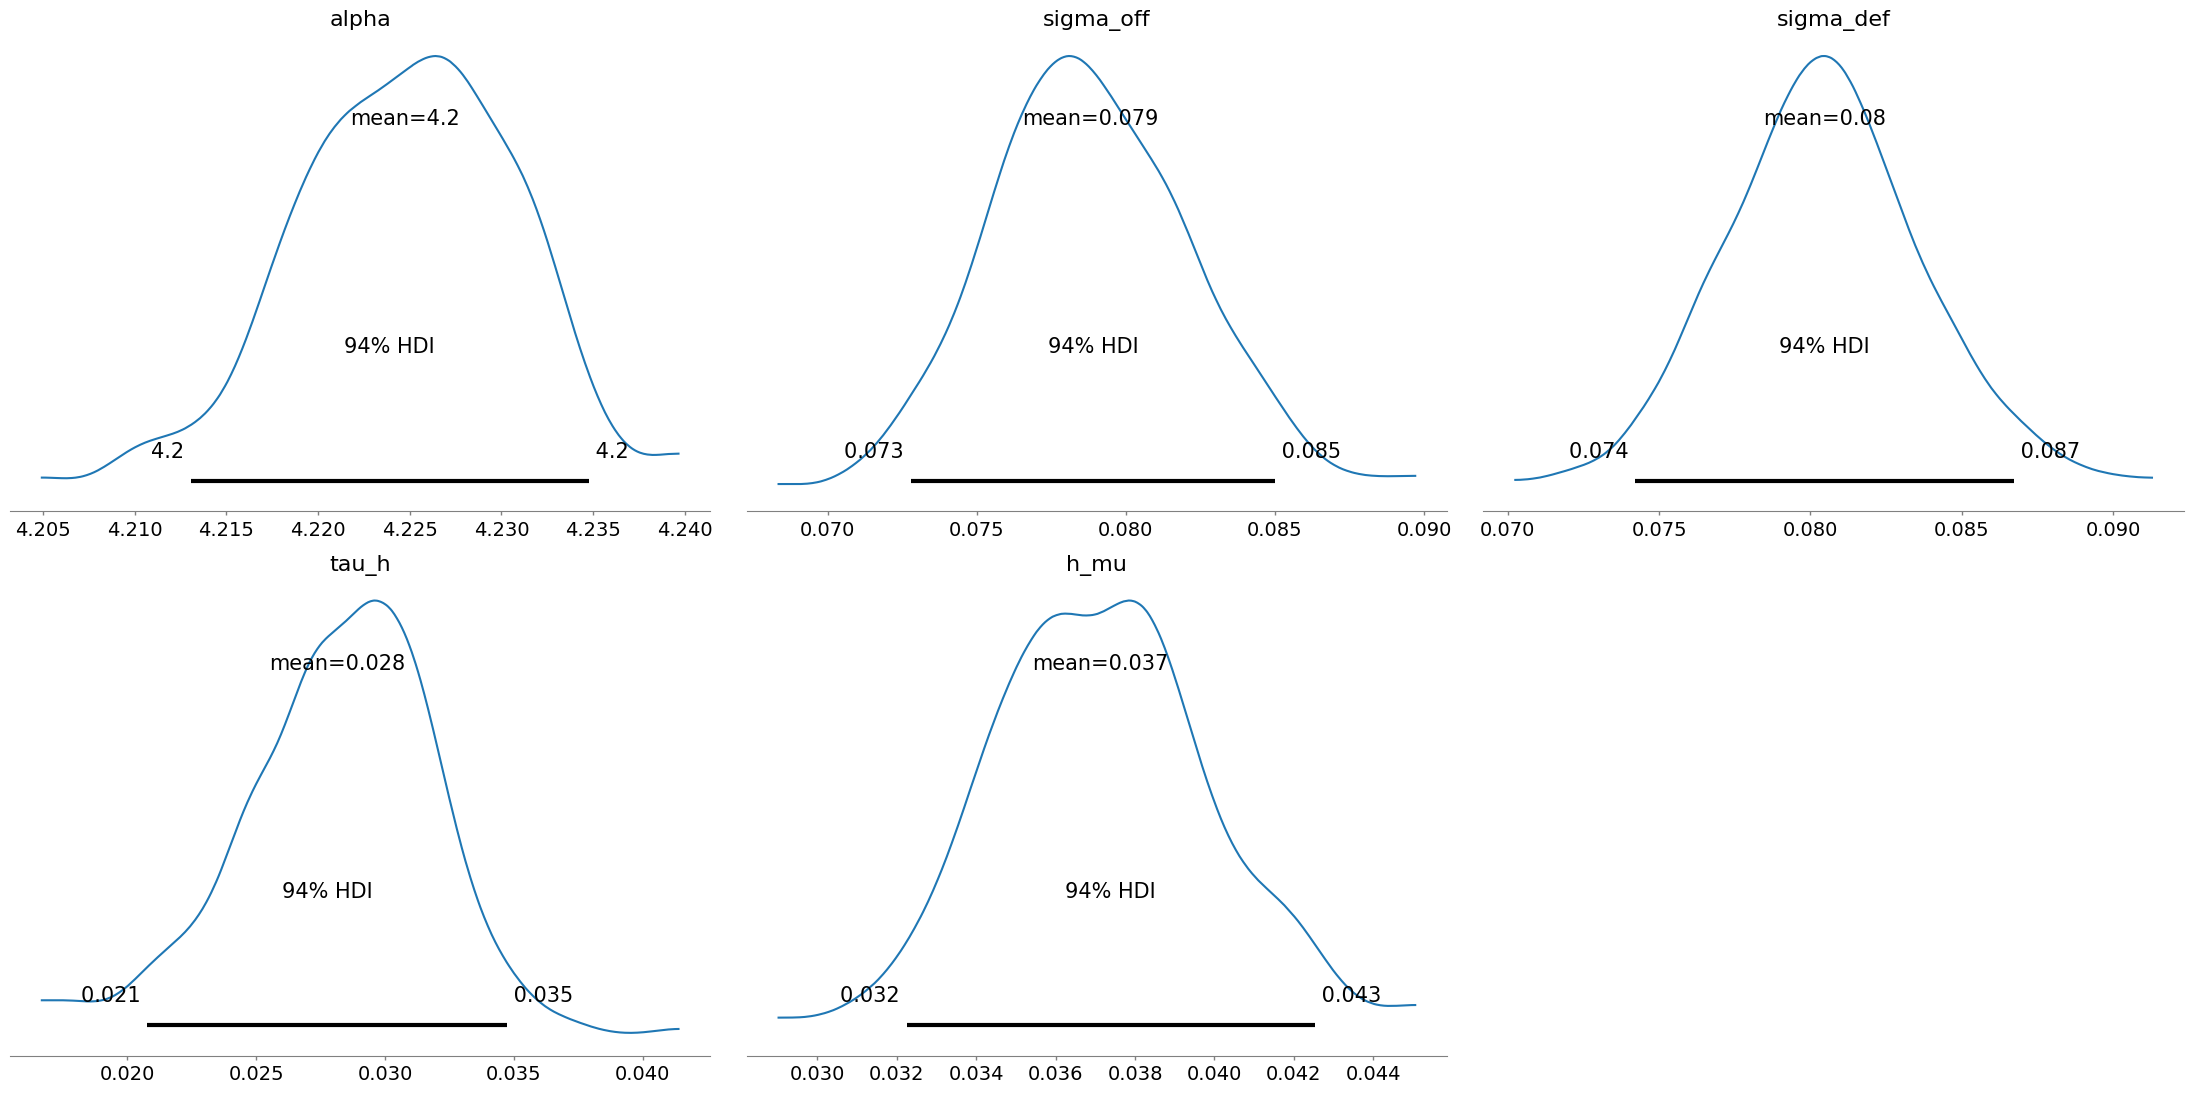

In [38]:
az.plot_posterior(arviz_object, var_names=["alpha", "sigma_off", "sigma_def", "tau_h", "h_mu"])
plt.tight_layout()
plt.show()

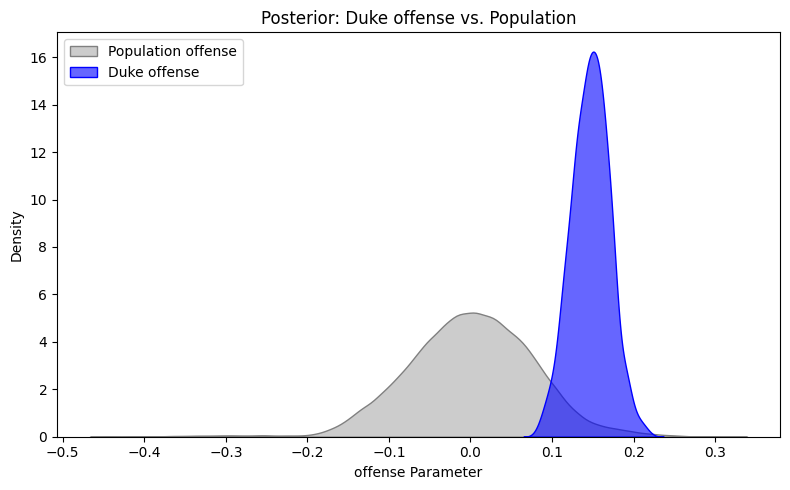

In [50]:
# Choose a team (e.g., Duke)
team_name = "Duke"
team_id = team_to_id[team_name]
param="offense"

# Get posterior samples for the team's offense parameter
team_offense = samples[param][:, team_id]
# Get posterior samples for the population mean offense (should be 0, but for illustration, use all teams)
all_offense = samples[param].reshape(-1)

# Plot the team's offense vs. the population
plt.figure(figsize=(8, 5))
sns.kdeplot(all_offense, label=f"Population {param}", fill=True, color="gray", alpha=0.4)
sns.kdeplot(team_offense, label=f"{team_name} {param}", fill=True, color="blue", alpha=0.6)
plt.title(f"Posterior: {team_name} {param} vs. Population")
plt.xlabel(f"{param} Parameter")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
for param, sample in samples.items():
    print(param, sample.mean())

alpha 4.224729267113206
defense -0.0005011401212914014
h 0.037162708498453406
h_mu 0.037127702198917735
offense 4.978393302676781e-06
sigma_def 0.08047589951693337
sigma_off 0.07879890092547445
tau_h 0.02814243906973277


In [75]:
# Find Duke's team ID
duke_id = team_to_id['Duke']
print(f"Duke's team ID: {duke_id}")

# Find another team for comparison (let's use North Carolina)
unc_id = team_to_id['North Carolina']
print(f"North Carolina's team ID: {unc_id}")

# Extract Duke's offense, defense, and home parameters
duke_offense = samples['offense'][:, duke_id]
duke_defense = samples['defense'][:, duke_id]
duke_home = samples['h'][:, duke_id]

# Extract North Carolina's offense, defense, and home parameters
unc_offense = samples['offense'][:, unc_id]
unc_defense = samples['defense'][:, unc_id]
unc_home = samples['h'][:, unc_id]

print(f"\n=== DUKE ===")
print(f"Offense:")
print(f"  Mean: {duke_offense.mean():.4f}")
print(f"  Standard deviation: {duke_offense.std():.4f}")
print(f"Defense:")
print(f"  Mean: {duke_defense.mean():.4f}")
print(f"  Standard deviation: {duke_defense.std():.4f}")
print(f"Home:")
print(f"  Mean: {duke_home.mean():.4f}")
print(f"  Standard deviation: {duke_home.std():.4f}")

print(f"\n=== NORTH CAROLINA ===")
print(f"Offense:")
print(f"  Mean: {unc_offense.mean():.4f}")
print(f"  Standard deviation: {unc_offense.std():.4f}")
print(f"Defense:")
print(f"  Mean: {unc_defense.mean():.4f}")
print(f"  Standard deviation: {unc_defense.std():.4f}")
print(f"Home:")
print(f"  Mean: {unc_home.mean():.4f}")
print(f"  Standard deviation: {unc_home.std():.4f}")

print(f"\n=== COMPARISON ===")
print(f"Offense difference (Duke - UNC): {duke_offense.mean() - unc_offense.mean():.4f}")
print(f"Defense difference (Duke - UNC): {duke_defense.mean() - unc_defense.mean():.4f}")
print(f"Home difference (Duke - UNC): {duke_home.mean() - unc_home.mean():.4f}")

# Calculate expected scores using the model's linear predictors
# This shows what the model predicts for actual game scores
alpha = samples['alpha'].mean()
duke_eta_home = alpha + duke_offense - unc_defense + duke_home
unc_eta_away = alpha + unc_offense - duke_defense

duke_expected_score = jnp.exp(duke_eta_home)
unc_expected_score = jnp.exp(unc_eta_away)

print(f"\n=== EXPECTED SCORES (Duke home vs UNC away) ===")
print(f"Duke expected score: {duke_expected_score.mean():.2f} ± {duke_expected_score.std():.2f}")
print(f"UNC expected score: {unc_expected_score.mean():.2f} ± {unc_expected_score.std():.2f}")

# Show some actual expected score samples
print(f"\nDuke expected scores (first 10): {duke_expected_score[:10]}")
print(f"UNC expected scores (first 10): {unc_expected_score[:10]}")

# Show sample values for both teams
print(f"\nDuke offense samples (first 10): {duke_offense[:10]}")
print(f"UNC offense samples (first 10): {unc_offense[:10]}")
print(f"Duke defense samples (first 10): {duke_defense[:10]}")
print(f"UNC defense samples (first 10): {unc_defense[:10]}")
print(f"Duke home samples (first 10): {duke_home[:10]}")
print(f"UNC home samples (first 10): {unc_home[:10]}")


Duke's team ID: 75
North Carolina's team ID: 200

=== DUKE ===
Offense:
  Mean: 0.1471
  Standard deviation: 0.0233
Defense:
  Mean: 0.0664
  Standard deviation: 0.0188
Home:
  Mean: 0.0515
  Standard deviation: 0.0212

=== NORTH CAROLINA ===
Offense:
  Mean: 0.1607
  Standard deviation: 0.0233
Defense:
  Mean: 0.0288
  Standard deviation: 0.0198
Home:
  Mean: 0.0201
  Standard deviation: 0.0231

=== COMPARISON ===
Offense difference (Duke - UNC): -0.0136
Defense difference (Duke - UNC): 0.0376
Home difference (Duke - UNC): 0.0314

=== EXPECTED SCORES (Duke home vs UNC away) ===
Duke expected score: 81.04 ± 2.19
UNC expected score: 75.15 ± 2.20

Duke expected scores (first 10): [83.5256231  79.85837897 81.29327682 79.78807967 84.81852324 80.70530545
 81.98817421 85.14189899 80.62326241 79.09605373]
UNC expected scores (first 10): [75.48204157 75.37417604 77.20903664 74.69428103 79.03227548 75.49558077
 76.61925434 76.40686476 76.52285437 73.02716469]

Duke offense samples (first 10): [

### Simulate team matchup

In [76]:
import numpy as np
import arviz as az

def simulate_match_pp(
    samples: dict,
    home_team: int,
    away_team: int,
    *,
    reps: int | None = None,       # how many simulated games; None => use all draws once (D)
    rng_seed: int | None = 0,
    make_plots: bool = True,
    return_idata: bool = True,
):
    """
    Posterior-predictive match simulation with FULL parameter uncertainty.

    Parameters
    ----------
    samples : dict
        From numpyro MCMC (mcmc.get_samples()). Must include: 'alpha','offense','defense','h'.
        Expected shapes:
          - alpha:   (D,) or (D,1)
          - offense: (D, T)
          - defense: (D, T)
          - h:       (D, T)
        where D = # draws, T = # teams (746 here).
    home_team, away_team : int
        0-based team indices.
    reps : int | None
        Number of posterior-predictive games to simulate.
        If None, uses every posterior draw exactly once (R = D).
        If set, draws R parameter sets *with replacement* from the D posterior draws.
    rng_seed : int | None
        RNG seed for reproducibility.
    make_plots : bool
        If True, show ArviZ posterior histograms for y_home, y_away, goal_diff.
    return_idata : bool
        If True, return ArviZ InferenceData.

    Returns
    -------
    dict with keys:
      y_home, y_away, goal_diff, p_home_win, p_draw, p_away_win, idata (maybe None)
    """
    rng = np.random.default_rng(rng_seed)

    # Pull and coerce shapes
    alpha   = np.asarray(samples["alpha"]).reshape(-1)          # (D,)
    offense = np.asarray(samples["offense"])                    # (D, T)
    defense = np.asarray(samples["defense"])                    # (D, T)
    h       = np.asarray(samples["h"])                          # (D, T)

    if offense.ndim != 2 or defense.ndim != 2 or h.ndim != 2:
        raise ValueError("offense/defense/h must be 2D (draws, teams).")
    D, T = offense.shape
    if defense.shape != (D, T) or h.shape != (D, T):
        raise ValueError(f"Shape mismatch: offense {offense.shape}, defense {defense.shape}, h {h.shape}")
    if alpha.shape[0] != D:
        raise ValueError(f"alpha draws {alpha.shape[0]} != team-effect draws {D}")
    if not (0 <= home_team < T and 0 <= away_team < T):
        raise IndexError(f"Team index out of range: home={home_team}, away={away_team}, T={T}")

    # Choose which posterior draws to use for the sims
    if reps is None:
        draw_idx = np.arange(D)              # use each draw once (R = D)
    else:
        draw_idx = rng.integers(0, D, size=int(reps))  # sample draws w/ replacement (R = reps)

    # Gather the selected draws
    a   = alpha[draw_idx]                    # (R,)
    off = offense[draw_idx, :]               # (R, T)
    de  = defense[draw_idx, :]               # (R, T)
    hh  = h[draw_idx, :]                     # (R, T)

    # Linear predictors & Poisson rates per simulated game
    eta_home = a + off[:, home_team] - de[:, away_team] + hh[:, home_team]   # (R,)
    eta_away = a + off[:, away_team] - de[:, home_team]                      # (R,)
    lam_home = np.exp(eta_home)
    lam_away = np.exp(eta_away)

    # Posterior predictive scores
    y_home = rng.poisson(lam_home)
    y_away = rng.poisson(lam_away)
    goal_diff = y_home - y_away

    # Outcome probabilities
    p_home_win = float((goal_diff > 0).mean())
    p_draw     = float((goal_diff == 0).mean())
    p_away_win = float((goal_diff < 0).mean())

    # Optional ArviZ packaging + quick plots
    idata = None
    if return_idata:
        idata = az.from_dict(
            posterior_predictive={
                "y_home":    y_home[None, :],    # (chain=1, draw=R)
                "y_away":    y_away[None, :],
                "goal_diff": goal_diff[None, :],
            }
        )
        if make_plots:
            az.plot_posterior(
                idata,
                var_names=["y_home", "y_away", "goal_diff"],
                group="posterior_predictive",
                kind="hist",
                hdi_prob=0.90,
            )
            print(
                f"Home win: {p_home_win:.3f} | Draw: {p_draw:.3f} | Away win: {p_away_win:.3f} "
                f"(based on {y_home.size} posterior-predictive sims)"
            )

    return {
        "y_home": y_home,
        "y_away": y_away,
        "goal_diff": goal_diff,
        "p_home_win": p_home_win,
        "p_draw": p_draw,
        "p_away_win": p_away_win,
        "idata": idata,
    }


Home win: 0.477 | Draw: 0.023 | Away win: 0.500 (based on 600 posterior-predictive sims)


(0.4766666666666667, 0.023333333333333334, 0.5)

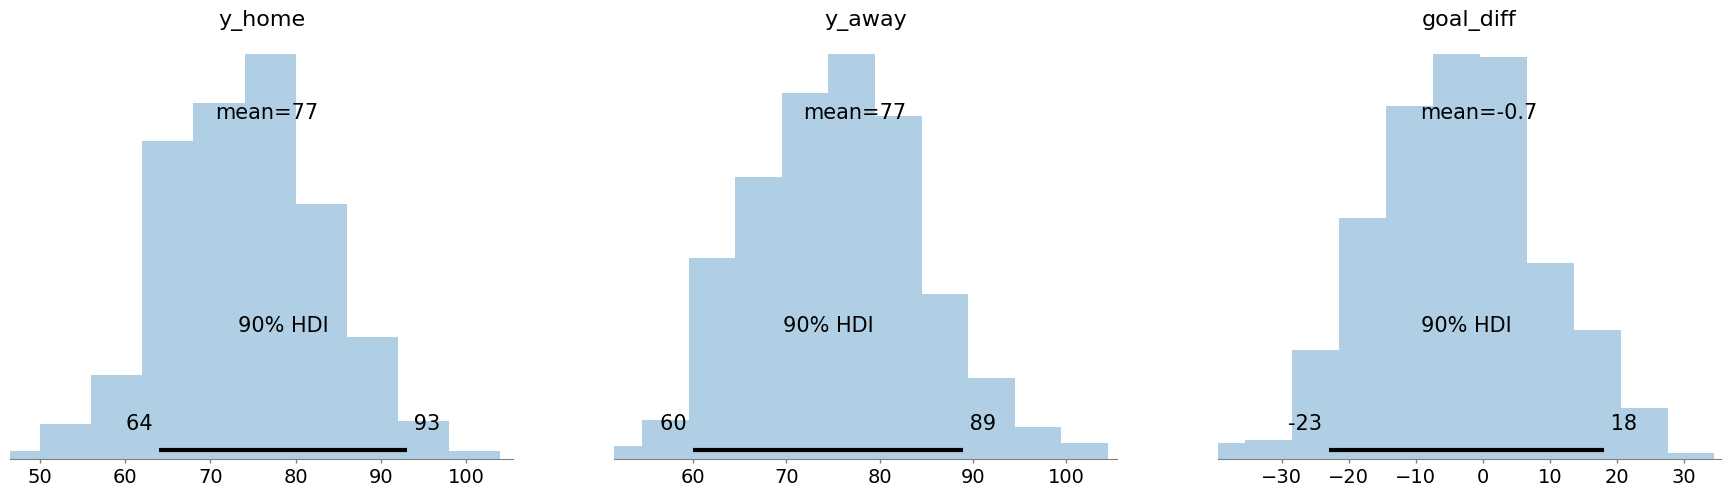

In [79]:
# D=600 draws, T=746 teams
out = simulate_match_pp(
    samples,
    home_team=200,
    away_team=75,
    reps=None,         # uses all 600 draws once (parameter uncertainty preserved)
    rng_seed=52,
    make_plots=True,
    return_idata=True,
)

out["p_home_win"], out["p_draw"], out["p_away_win"]


# Step 2: Game-level correlation, team-level error bands:

In [90]:
# ---------- Model: Poisson-lognormal w/ shared game factor + team σ ----------
def model_pln_single_factor(
    home_idx: jnp.ndarray,
    away_idx: jnp.ndarray,
    y_home:  jnp.ndarray,
    y_away:  jnp.ndarray,
    n_teams: int,
):
    """
    log λ_home = α + off[home] - def[away] + h[home] + g_game + ε_home
    log λ_away = α + off[away] - def[home]          + g_game + ε_away

    g_game ~ N(0, σ_g^2) is shared (induces within-game correlation).
    ε_side ~ N(0, σ_inc[team]^2) is team-specific inconsistency.
    """
    n_games = y_home.shape[0]

    # Global scales
    alpha     = numpyro.sample("alpha",     dist.Normal(0.0, 5.0))
    sigma_off = numpyro.sample("sigma_off", dist.HalfNormal(1.0))
    sigma_def = numpyro.sample("sigma_def", dist.HalfNormal(1.0))
    tau_h     = numpyro.sample("tau_h",     dist.HalfNormal(1.0))

    # Non-centered team effects (then soft sum-to-zero for identifiability)
    with numpyro.plate("team", n_teams):
        off_raw = numpyro.sample("off_raw", dist.Normal(0, 1))
        def_raw = numpyro.sample("def_raw", dist.Normal(0, 1))
        h_raw   = numpyro.sample("h_raw",   dist.Normal(0, 1))

    off   = sigma_off * (off_raw - jnp.mean(off_raw))
    deff  = sigma_def * (def_raw - jnp.mean(def_raw))
    hteam = tau_h     * (h_raw   - jnp.mean(h_raw))

    # Team-specific inconsistency (hierarchical)
    tau_inc = numpyro.sample("tau_inc", dist.HalfNormal(0.5))
    with numpyro.plate("team_inc", n_teams):
        sigma_inc = numpyro.sample("sigma_inc", dist.HalfNormal(tau_inc))

    # Shared game factor → positive within-game covariance
    sigma_g = numpyro.sample("sigma_g", dist.HalfNormal(0.5))
    g = numpyro.sample("g", dist.Normal(0, 1).expand([n_games])) * sigma_g  # (n_games,)

    # Team-specific shocks on the log-rate (lognormal layer)
    eps_h = numpyro.sample("eps_home", dist.Normal(0, 1).expand([n_games])) * sigma_inc[home_idx]
    eps_a = numpyro.sample("eps_away", dist.Normal(0, 1).expand([n_games])) * sigma_inc[away_idx]

    # Linear predictors
    eta_home = alpha + off[home_idx] - deff[away_idx] + hteam[home_idx] + g + eps_h
    eta_away = alpha + off[away_idx] - deff[home_idx]                    + g + eps_a

    # Poisson-lognormal likelihood
    lam_home = jnp.exp(eta_home)
    lam_away = jnp.exp(eta_away)
    numpyro.sample("y_home", dist.Poisson(lam_home), obs=y_home)
    numpyro.sample("y_away", dist.Poisson(lam_away), obs=y_away)



In [ ]:
kernel = NUTS(model_pln_single_factor, dense_mass=False)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=2, chain_method="sequential")
rng = jax.random.PRNGKey(0)
mcmc.run(
    rng,
    home_idx=encoded.home_idx,
    away_idx=encoded.away_idx,
    y_home=encoded.y_home,
    y_away=encoded.y_away,
    n_teams=encoded.n_teams,
)
single_factor_samples = mcmc.get_samples()


sample: 100%|██████████| 3000/3000 [07:46<00:00,  6.44it/s, 127 steps of size 4.80e-02. acc. prob=0.93]


In [ ]:
# Compute mean for each parameter in single_factor_samples
param_means = {k: np.mean(v, axis=0) for k, v in single_factor_samples.items()}

# For scalar parameters, just print the mean
# For vector parameters, show a summary (mean, std, shape)
summary = []
for k, v in single_factor_samples.items():
    mean = np.mean(v, axis=0)
    if mean.shape == ():  # scalar
        summary.append({'parameter': k, 'mean': mean})
    else:
        summary.append({
            'parameter': k,
            'mean': mean.mean(),
            'std': mean.std(),
            'shape': mean.shape
        })

df_summary = pd.DataFrame(summary)
print(df_summary)


    parameter                     mean                     std    shape
0       alpha        4.241364726138412                     NaN      NaN
1     def_raw    0.0024857245877522214      0.9515100517668571   (360,)
2    eps_away    -0.003718830159789134      0.0232594681216657  (5489,)
3    eps_home    0.0035475649596216135    0.023404432609004013  (5489,)
4           g  -5.2423722537662936e-05      0.6484758810445026  (5489,)
5       h_raw   -0.0002771881458829167      0.1658398309176501   (360,)
6     off_raw  -0.00027805580339758233      0.9478138805517639   (360,)
7   sigma_def      0.08482782473919741                     NaN      NaN
8     sigma_g      0.07617989126972381                     NaN      NaN
9   sigma_inc     0.003145640712217544  4.9599474936534366e-05   (360,)
10  sigma_off      0.08344477939767793                     NaN      NaN
11      tau_h     0.008554000870636208                     NaN      NaN
12    tau_inc     0.003953415595263655                     NaN  

In [94]:
def _reconstruct_team_params(samples):
    """
    Rebuilds offense, defense, and home-edge from raw draws using the same
    per-draw mean-centering as in the model.
    """
    off_raw = samples["off_raw"]      # (S, T)
    def_raw = samples["def_raw"]      # (S, T)
    h_raw   = samples["h_raw"]        # (S, T)
    sig_off = samples["sigma_off"]    # (S,)
    sig_def = samples["sigma_def"]    # (S,)
    tau_h   = samples["tau_h"]        # (S,)

    off   = sig_off[:, None] * (off_raw - off_raw.mean(axis=1, keepdims=True))
    deff  = sig_def[:, None] * (def_raw - def_raw.mean(axis=1, keepdims=True))
    hteam = tau_h[:,   None] * (h_raw   - h_raw.mean(axis=1, keepdims=True))
    return off, deff, hteam

def simulate_match_pp(
    samples: dict,
    home_team: str | int,
    away_team: str | int,
    team_to_idx: dict[str, int] | None = None,
    reps: int | None = None,
    neutral_site: bool = False,
    rng_seed: int = 0,
):
    """
    Monte Carlo posterior predictive for one matchup (home vs away).

    Args
    ----
    samples      : dict from numpyro.get_samples()
    home_team    : team name or index
    away_team    : team name or index
    team_to_idx  : mapping name->index if passing names
    reps         : number of posterior draws to use (default: all)
    neutral_site : if True, removes home-edge term h[home]
    rng_seed     : JAX PRNG seed

    Returns
    -------
    dict with p_home_win, p_draw, p_away_win, score summaries, and a
    (reduced) table of lambda means.
    """
    # Resolve indices
    if isinstance(home_team, str):
        assert team_to_idx is not None and home_team in team_to_idx, "unknown home team"
        hi = team_to_idx[home_team]
    else:
        hi = int(home_team)
    if isinstance(away_team, str):
        assert team_to_idx is not None and away_team in team_to_idx, "unknown away team"
        ai = team_to_idx[away_team]
    else:
        ai = int(away_team)

    S = samples["alpha"].shape[0]  # number of posterior draws
    draw_idx = np.arange(S) if reps is None or reps >= S else np.random.default_rng(42).choice(S, size=reps, replace=False)
    # Slice draws
    alpha   = samples["alpha"][draw_idx]           # (R,)
    sigma_g = samples["sigma_g"][draw_idx]         # (R,)
    sigma_inc = samples["sigma_inc"][draw_idx, :]  # (R, T)

    # Reconstruct team effects for chosen draws
    off_full, def_full, h_full = _reconstruct_team_params({k: v[draw_idx] if v.ndim>1 or k in ["alpha","sigma_off","sigma_def","tau_h"] else v[draw_idx] 
                                                           for k, v in samples.items()})
    off_h = off_full[:, hi]     # (R,)
    def_h = def_full[:, hi]
    h_h   = h_full[:, hi]
    off_a = off_full[:, ai]
    def_a = def_full[:, ai]

    # Build linear predictors
    # eta_home = alpha + off[home] - def[away] + h[home] + g + eps_home
    # eta_away = alpha + off[away] - def[home]        + g + eps_away
    R = alpha.shape[0]
    key = jax.random.PRNGKey(rng_seed)
    k1, k2, k3, k4 = jax.random.split(key, 4)

    g = jax.random.normal(k1, (R,)) * sigma_g
    eps_home = jax.random.normal(k2, (R,)) * sigma_inc[:, hi]
    eps_away = jax.random.normal(k3, (R,)) * sigma_inc[:, ai]

    h_term = 0.0 if neutral_site else h_h
    eta_home = alpha + off_h - def_a + h_term + g + eps_home
    eta_away = alpha + off_a - def_h          + g + eps_away

    lam_home = jnp.exp(eta_home)
    lam_away = jnp.exp(eta_away)

    y_home = jax.random.poisson(k4, lam=lam_home)
    # fresh key for away to avoid coupling
    y_away = jax.random.poisson(jax.random.split(k4, 2)[1], lam=lam_away)

    # Probabilities
    p_home = float((y_home >  y_away).mean())
    p_draw = float((y_home == y_away).mean())
    p_away = float((y_home <  y_away).mean())

    out = {
        "p_home_win": p_home,
        "p_draw":     p_draw,
        "p_away_win": p_away,
        "home_pts":   {
            "mean": float(y_home.mean()),
            "median": float(jnp.median(y_home)),
            "p05": float(jnp.quantile(y_home, 0.05)),
            "p95": float(jnp.quantile(y_home, 0.95)),
        },
        "away_pts":   {
            "mean": float(y_away.mean()),
            "median": float(jnp.median(y_away)),
            "p05": float(jnp.quantile(y_away, 0.05)),
            "p95": float(jnp.quantile(y_away, 0.95)),
        },
        "lambda_means": {
            "home": float(lam_home.mean()),
            "away": float(lam_away.mean()),
        },
        "draws_used": int(R),
        "neutral_site": bool(neutral_site),
        "home_idx": hi,
        "away_idx": ai,
    }
    return out


In [110]:
simulate_match_pp(single_factor_samples, home_team=200, away_team=232, reps=100_000)

{'p_home_win': 0.8142500519752502,
 'p_draw': 0.01900000125169754,
 'p_away_win': 0.1667500138282776,
 'home_pts': {'mean': 84.075, 'median': 84.0, 'p05': 66.0, 'p95': 104.0},
 'away_pts': {'mean': 72.10175, 'median': 72.0, 'p05': 56.0, 'p95': 90.0},
 'lambda_means': {'home': 84.00908588072603, 'away': 72.24670258822023},
 'draws_used': 4000,
 'neutral_site': False,
 'home_idx': 200,
 'away_idx': 232}

In [109]:
team_to_id['Princeton']

232